In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

folder_path = '/content/drive/MyDrive'
print(os.listdir(folder_path))

['archive (1).zip', 'Colab Notebooks', 'modified_chestxray_pneumonia']


In [ ]:
print(os.listdir('/content/drive/MyDrive/modified_chestxray_pneumonia'))

['__MACOSX', 'test', 'train', 'val']


In [ ]:
import keras
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import cv2
import sklearn
import shap
import os
import seaborn as sns
import time
import pickle


In [ ]:
import h5py
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D, BatchNormalization, Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2


In [ ]:
#Loading Datsets
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory


train_dir = '/content/drive/MyDrive/modified_chestxray_pneumonia/train'
val_dir   = '/content/drive/MyDrive/modified_chestxray_pneumonia/val'
test_dir  = '/content/drive/MyDrive/modified_chestxray_pneumonia/test'



In [ ]:
batch_size = 32
img_size = (224, 224)

# Create raw datasets
train_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale'
)

val_raw = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale'
)

test_raw = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale'
)

# ✅ Get class names before transformation
class_names = train_raw.class_names
print("Classes:", class_names)
print("Total Classes:", len(class_names))

# Convert grayscale to RGB
def convert_gray_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

AUTOTUNE = tf.data.AUTOTUNE

# Apply mapping + prefetch
train_ds = train_raw.map(convert_gray_to_rgb).prefetch(buffer_size=AUTOTUNE)
val_ds = val_raw.map(convert_gray_to_rgb).prefetch(buffer_size=AUTOTUNE)
test_ds = test_raw.map(convert_gray_to_rgb).prefetch(buffer_size=AUTOTUNE)


Found 4360 files belonging to 2 classes.
Found 872 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']
Total Classes: 2


In [ ]:
for images,labels in train_ds.take(1):
  print('Image batch shape',images.shape)
  print("Labels shape",labels.shape)

Image batch shape (32, 224, 224, 3)
Labels shape (32,)


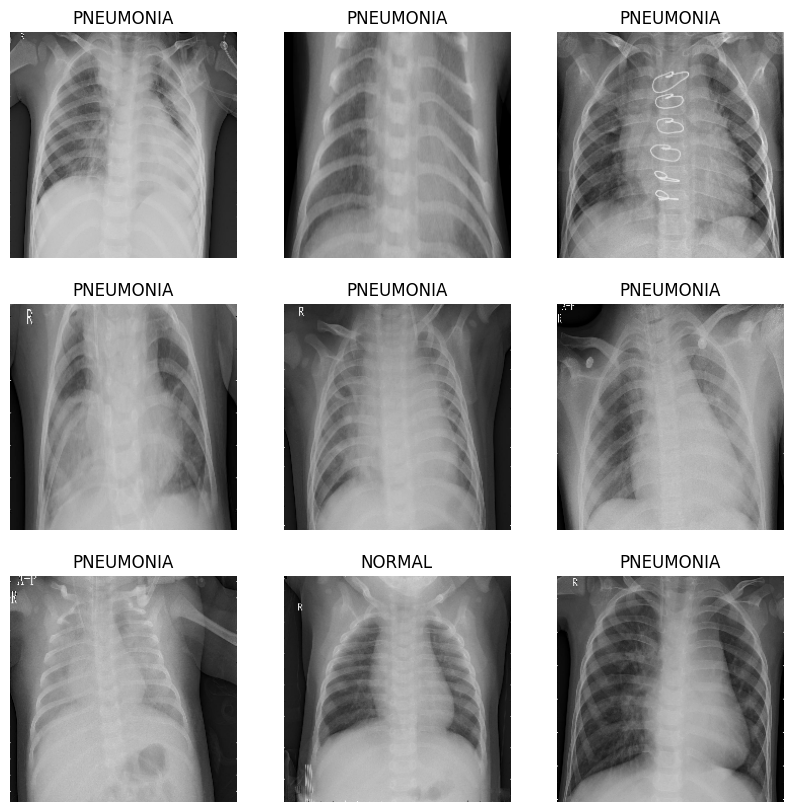

In [ ]:
##seeing general data
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'), cmap='gray')
        label_idx = labels[i].numpy()  # already 0 or 1
        plt.title(class_names[label_idx])
        plt.axis('off')

In [ ]:
#counting Images per class
dataset_path = '/content/drive/MyDrive/modified_chestxray_pneumonia/train'
class_counts = {}

for class_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(folder_path):
        class_counts[class_name] = len(os.listdir(folder_path))

print("Image count per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")


Image count per class:
NORMAL: 913
PNEUMONIA: 3447


In [ ]:
for images,_ in train_ds.take(1):
  print("Resized Images",images[0].shape)

Resized Images (224, 224, 3)


In [ ]:
##for imbalanced data -- data augmentation with weights intialization
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
])

In [ ]:
#augmentation + optimizing pipeline
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
##class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
class_names = ['NORMAL', 'PNEUMONIA']
image_counts = [1341, 3875]

y = np.repeat(np.arange(len(class_names)), image_counts)

class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y),
    y=y
)

class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


In [ ]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)

    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)

    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(1, activation='sigmoid', name='fc3')(x)

    model = Model(inputs=input_img, outputs=x)
    return model

In [ ]:
model =  build_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ImageInput (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1_1 (Conv2D)                │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1_2 (Conv2D)                │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2_1 (SeparableConv2D)       │ (None, 112, 112, 128)  │         8,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2_2 (SeparableConv2D)       │ (None, 112, 112, 128)  │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3_1 (SeparableConv2D)       │ (None, 56, 56, 256)    │        34,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 56, 56, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3_2 (SeparableConv2D)       │ (None, 56, 56, 256)    │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 56, 56, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3_3 (SeparableConv2D)       │ (None, 56, 56, 256)    │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4_1 (SeparableConv2D)       │ (None, 28, 28, 512)    │       133,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 28, 28, 512)    │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4_2 (SeparableConv2D)       │ (None, 28, 28, 512)    │       267,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 28, 28, 512)    │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4_3 (SeparableConv2D)       │ (None, 28, 28, 512)    │       267,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 1024)           │   102,761,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 1)              │           51

 Total params: 104,196,993 (397.48 MB)

 Trainable params: 104,193,921 (397.47 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5 to vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5


In [ ]:
import os
print(os.listdir())


['.config', 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'drive', 'sample_data']


In [ ]:
import h5py

with h5py.File('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r') as f:
    layer_map = {
        'Conv1_1': 'block1_conv1',
        'Conv1_2': 'block1_conv2',
        'Conv2_1': 'block2_conv1',
        'Conv2_2': 'block2_conv2'
    }

    for your_layer_name, vgg_layer_name in layer_map.items():
        target_layer = model.get_layer(your_layer_name)

        # Try only if layer expects 2 weights
        if len(target_layer.weights) == 2:
            w = f[vgg_layer_name][f"{vgg_layer_name}_W_1:0"][()]
            b = f[vgg_layer_name][f"{vgg_layer_name}_b_1:0"][()]
            target_layer.set_weights([w, b])
        else:
            print(f"Skipping {your_layer_name} (likely SeparableConv2D, incompatible with Conv2D weights)")


Skipping Conv2_1 (likely SeparableConv2D, incompatible with Conv2D weights)
Skipping Conv2_2 (likely SeparableConv2D, incompatible with Conv2D weights)


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ImageInput (InputLayer)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1_1 (Conv2D)                │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1_2 (Conv2D)                │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2_1 (SeparableConv2D)       │ (None, 112, 112, 128)  │         8,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2_2 (SeparableConv2D)       │ (None, 112, 112, 128)  │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3_1 (SeparableConv2D)       │ (None, 56, 56, 256)    │        34,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 56, 56, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3_2 (SeparableConv2D)       │ (None, 56, 56, 256)    │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 56, 56, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3_3 (SeparableConv2D)       │ (None, 56, 56, 256)    │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4_1 (SeparableConv2D)       │ (None, 28, 28, 512)    │       133,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 28, 28, 512)    │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4_2 (SeparableConv2D)       │ (None, 28, 28, 512)    │       267,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 28, 28, 512)    │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4_3 (SeparableConv2D)       │ (None, 28, 28, 512)    │       267,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 1024)           │   102,761,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 1)              │           51

 Total params: 104,196,993 (397.48 MB)

 Trainable params: 104,193,921 (397.47 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [ ]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

opt = Adam(learning_rate=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)

chkpt = ModelCheckpoint(
    filepath='best_model_todate.weights.h5',
    save_best_only=True,
    save_weights_only=True
)

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[es, chkpt],
    class_weight={0: 1.0, 1: 0.4}
)

Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.8543 - loss: 0.2168 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 92s 312ms/step - accuracy: 0.9417 - loss: 0.0770 - val_accuracy: 0.5000 - val_loss: 0.7047
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 43s 312ms/step - accuracy: 0.9705 - loss: 0.0455 - val_accuracy: 0.5000 - val_loss: 0.7973
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 118s 575ms/step - accuracy: 0.9804 - loss: 0.0309 - val_accuracy: 0.5069 - val_loss: 0.6008
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 83s 586ms/step - accuracy: 0.9850 - loss: 0.0203 - val_accuracy: 0.9667 - val_loss: 0.1085
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 45s 313ms/step - accuracy: 0.9850 - loss: 0.0233 - val_accuracy: 0.9381 - val_loss: 0.1875
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 114s 550ms/step - accuracy: 0.9890 - loss: 0.0178 - val_accuracy: 0.9748 - val_loss: 0.0571
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 83s 561ms/step - accuracy: 0.9873 - loss: 0

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"🧪 Test Loss: {test_loss:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step - accuracy: 0.7077 - loss: 4.2290
✅ Test Accuracy: 0.7083
🧪 Test Loss: 3.9672


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step


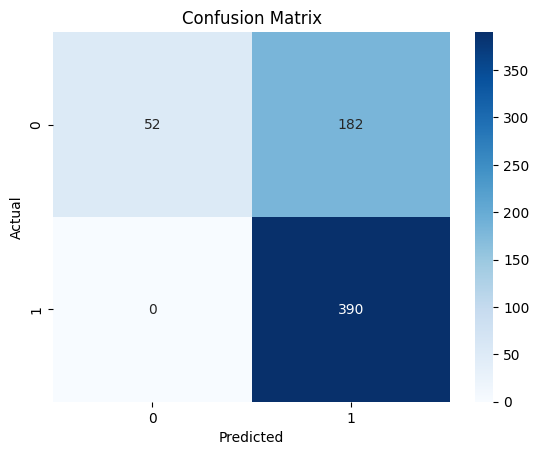

              precision    recall  f1-score   support

      Normal       1.00      0.22      0.36       234
   Pneumonia       0.68      1.00      0.81       390

    accuracy                           0.71       624
   macro avg       0.84      0.61      0.59       624
weighted avg       0.80      0.71      0.64       624



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    preds = model.predict(images)
    y_pred.extend((preds > 0.5).astype("int").flatten())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))


In [ ]:
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 1.00
Precision of the model is 0.68


In [ ]:
# Example: assume `model` is your trained model
model.save("resume_model.keras")


In [ ]:
from google.colab import files
files.download("resume_model.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
import gdown
import os

# Step 1: Download the model file from Google Drive
url = "https://drive.google.com/uc?id=1PrnplcVx32W6_KGXXkknFqp6i9wO27GQ"  # direct link format
output_path = "resume_model.keras"

if not os.path.exists(output_path):
    print("Downloading model...")
    gdown.download(url, output_path, quiet=False)

# Step 2: Load the model locally
print("Loading model...")
model = tf.keras.models.load_model(output_path)

# Step 3: Convert to TFLite
print("Converting to TFLite...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Step 4: Save the TFLite model
with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite model saved as 'model.tflite'")


Downloading...
From (original): https://drive.google.com/uc?id=1PrnplcVx32W6_KGXXkknFqp6i9wO27GQ
From (redirected): https://drive.google.com/uc?id=1PrnplcVx32W6_KGXXkknFqp6i9wO27GQ&confirm=t&uuid=7bc0704c-5145-46c4-8df3-e91a95276185
To: /content/resume_model.keras
100%|██████████| 1.25G/1.25G [00:17<00:00, 72.8MB/s]


Loading model...
Converting to TFLite...
Saved artifact at '/tmp/tmp_hsvw7cw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='ImageInput')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140047081262928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140047081261008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140047081265808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140047081265040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140047081264656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140047081266192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140047081266960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140047081266768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140047081267728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140047081267920: TensorSpec(shape=(), dtype=t

In [ ]:
from google.colab import files
files.download("model.tflite")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>